<h1 align=center><font size = 5>Forecasting Stock Prices Using Time Series</font></h1>
<h1 align=center><font size = 4>By</font></h1>
<h1 align=center><font size = 4>Norman Angel Agong</font></h1>
<h1 align=center><font size = 4>Email: anormanangel@gmail.com</font></h1>
</font></h1>

## Introduction

In this project, I will forecast APPLE stock prices using the ARIMA Model and implement a trading strategy using Trend Following approach. The trading idea is based on historical data and observe the results

### Autoregressive Integrated Moving Average (ARIMA)

An autoregressive integrated moving average, or ARIMA, is a statistical analysis model that uses time series data to predict future trends. it predicts future values based on past values

### ARIMA Parameters

For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:

* p: the number of lag observations in the model, also known as the lag order.
* d: the number of times the raw observations are differenced; also known as the degree of differencing.
* q: the size of the moving average window, also known as the order of the moving average.

### importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

### Installing Yahoo Finance

In [ ]:
#Installing Yahoo Finance to obatain stock data

!pip install yfinance

In [ ]:
#Importing Yahoo Finance

import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
# Getting Apple Stock Data

#Fetching Apple Data from Yahoo Finance for the last 10 Years [Jan 2012 to Dec 2022]

df = yf.download('AAPL', start = '2024-2-10', end = '2024-12-11')

[*********************100%%**********************]  1 of 1 completed


### Explore the dataset

In [ ]:
#Visualize the first 5 rows of the apple dataset

df.head()

# Our target variable will be the Close value.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-09,188.649994,189.990005,188.0,188.850006,188.850006,43728065


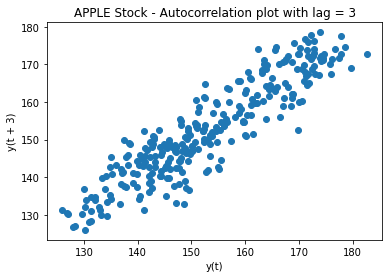

In [ ]:
# Check if there is some cross-correlation in our data.

plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('APPLE Stock - Autocorrelation plot with lag = 3')
plt.show()

### Plot the stock price evolution over time.

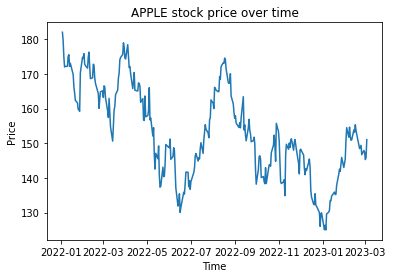

In [ ]:
plt.plot(df["Close"])
plt.title("APPLE stock price over time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

### Checking for Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df["Close"])

# Print the ADF test results
print('Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#  The code  checks for stationarity using the p-value and the significance level.
#  If the p-value is less than 0.05, it concludes that the time series is stationary.
#  If not, it uses the critical value for a 95% confidence level to check for stationarity.

if result[1] < 0.05:
    print('The time series is stationary.')
else:
    if result[0] < result[4]['5%']:
        print('The time series is stationary.')
    else:
        print('The time series is not stationary.')

Test Statistic: -2.716453
p-value: 0.071234
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
The time series is not stationary.


### Differencing to make data stationary by removing trends and seasonality 



In [ ]:
# Difference the time series
diff = np.diff(df["Close"])

# Perform ADF test on the differenced time series to check for stationarity
result_diff = adfuller(diff)

if result_diff[1] < 0.05:
    print('The time series is stationary.')
else:
    if result_diff[0] < result[4]['5%']:
        print('The time series is stationary.')
    else:
        print('The time series is not stationary.')


The time series is stationary.


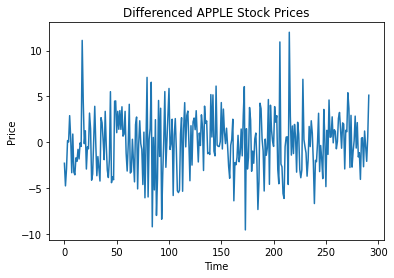

In [ ]:
# Plot the differenced time series

plt.plot(diff)
plt.title("Differenced APPLE Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

### Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


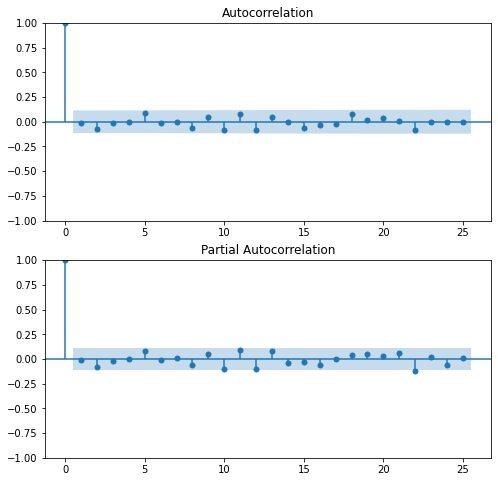

In [ ]:
# Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the differenced data to identif the order of ARIMA models. 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(diff, ax=ax1)
plot_pacf(diff, ax=ax2)
plt.show()

### Finding the best ARIMA model

In [ ]:
### Finding the best ARIMA model by evaluating all combinations of specified 𝑝, d, q values and selecting the one that minimizes the AIC.

import statsmodels.api as sm
import itertools

# Define the range of p, d, q values to be tested
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all possible combinations of p, d, q values
pdq = list(itertools.product(p, d, q))

# Fit ARIMA models on each combination of p, d, q values and select the model with the lowest AIC value
best_aic, best_pdq = float("inf"), None
for params in pdq:
    try:
        mod = sm.tsa.ARIMA(diff, order=params)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic, best_pdq = results.aic, params
    except:
        continue

p, d, q = best_pdq

print("Optimal p, d, q values obtained using AIC: ", p, d, q)



/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimal p, d, q values obtained using AIC:  1 1 2


### Fit the ARIMA model with the optimal parameters

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -757.338
Date:                Mon, 06 Mar 2023   AIC                           1522.677
Time:                        18:45:44   BIC                           1537.370
Sample:                             0   HQIC                          1528.563
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8980      0.039    -22.862      0.000      -0.975      -0.821
ma.L1         -0.0205      1.979     -0.010      0.992      -3.899       3.858
ma.L2         -0.9793      1.939     -0.505      0.6

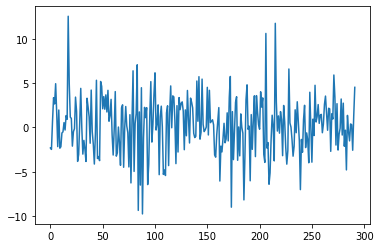

In [ ]:
# Fit the ARIMA model with the optimal parameters found previously, prints a summary of the fitted model, and plots the residuals of the model.

from statsmodels.tsa.arima.model import ARIMA
# Fit the ARIMA model
model = ARIMA(diff, order=(p, d, q))
result = model.fit()

# Print the model summary
print(result.summary())

# Plot the residuals
plt.plot(results.resid)
plt.show()

### Forecast the stock prices

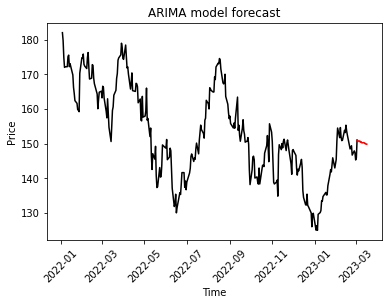

In [ ]:
# Plot the original data
plt.plot(df['Close'], color='black')
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Price')

# Use the model to predict the next n time periods
n_periods = 10
forecast = result.forecast(steps=n_periods)

# Create a new date index for the forecasted values
forecast_index = pd.date_range(df.index[-1], periods=n_periods + 1, freq='B')[1:]

# Convert the forecasted difference series to the original scale
forecast_diff_cumsum = np.cumsum(forecast)
forecast_values = pd.Series(df['Close'].iloc[-1], index=[df.index[-1]]).append(pd.Series(df['Close'].iloc[-1] + forecast_diff_cumsum, index=forecast_index))

# Plot the forecasted values
plt.plot(forecast_values, color='red')
plt.title('ARIMA model forecast')
plt.xlabel('Time')
plt.xticks(rotation=45)

plt.ylabel('Price')
plt.show()

### Calculate the returns using the Buy and Hold strategy

In [ ]:
# Calculate the returns using the Buy and Hold strategy
initial_price = df['Close'][0]
final_price = df['Close'][-1]
returns_bh = (final_price - initial_price) / initial_price

# Print the returns
print("Returns using Buy and Hold strategy: {:.2%}".format(returns_bh))

Returns using Buy and Hold strategy: -17.02%


In [ ]:
# Get the last day's closing price
last_day_price = df['Close'][-1]
last_day_price

151.02999877929688

### Forecast thd prices for the next 10 days

In [ ]:
# Use the model to predict the next 10 days' prices
n_periods = 10
forecast = result.forecast(steps=n_periods, alpha=0.05)

# Print the forecasted prices
print("Forecasted prices for the next 10 days:")
for price in forecast:
    print(f"${price + last_day_price:.2f}")


Forecasted prices for the next 10 days:
$150.62
$151.19
$150.68
$151.14
$150.73
$151.10
$150.76
$151.06
$150.80
$151.04


In [ ]:
import numpy as np

n_periods = 2  # Number of periods between the last day and day 8 (assuming day 8 is 8th period)
forecast = result.forecast(steps=n_periods, alpha=0.05)

# Get the forecasted price for day 2
day_2_forecast = forecast[-1] + last_day_price

print(f"Forecasted price for day 2: ${day_2_forecast:.2f}")


Forecasted price for day 2: $151.19


In [ ]:
roi = (day_2_forecast - last_day_price) / last_day_price
print(f"ROI from last day to day 2: {roi:.2%}")

ROI from last day to day 2: 0.11%


### Recomendation & Conclusion 

* Buying and holding an investment is a common approach, but it might not always yield the highest returns. For example, in this case, if we had bought and held the investment from the first day until today, we would have lost 17.02% of our investment.

* However, the ARIMA model offers a way to predict the ROI of the investment in 2 days, which is forecasted to be 0.11%. This is a small but positive return, and it suggests that the ARIMA model might be a better approach to investment than buying and holding.

* It's important to keep in mind that the ARIMA model's predictions aren't always spot-on, and many factors can affect an investment's price, such as market trends, news events, and global economic conditions. Nonetheless, the ARIMA model can still be a useful tool to assist us in making informed investment decisions.